In [14]:
%pylab inline

import logging as log
import fiona, shapely

contacts = "../input_data/contacts/contacts.shp"
units_ids = "../input_data/unit_id/unit_id.shp"

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist', 'Polygon', 'log', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [15]:
import logging as log
import fiona, shapely
import shapely.geometry

def load_shapefile(shpfile):
    con = fiona.open(shpfile)
    lines = []
    for l in con:
        geom = l["geometry"]
        i = l["id"]
        if geom is None:        
            log.warning(f"empty goemetry for record with id {i} in {shpfile}")
            continue

        shp_geom = shapely.geometry.shape(geom)
        lines.append(shp_geom)
        
    return con, lines

def extract_field(fionaobj, fname = "unit_name"):
    return [l["properties"][fname] for l in fionaobj]

In [16]:
flines, lines = load_shapefile(contacts)



# plot the data just to have an idea

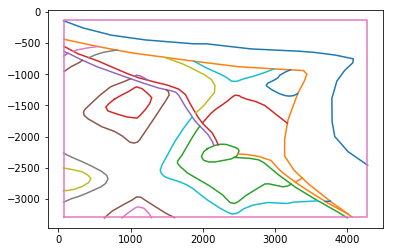

In [17]:
for l in lines:
    plot(l.xy[0], l.xy[1])

# as a multiline string

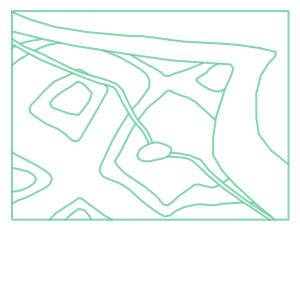

In [18]:
from shapely.geometry import MultiLineString, Polygon, LineString, MultiPolygon

lset = MultiLineString(lines)
lset

# We extend the lines of a fixed distance at each end

In [19]:
dist = 1

def extend(p1, p2, dist):
    v = p2 - p1
    v = v/np.linalg.norm(v) * dist
    
    news = p2 + v
    return news

out = []
for f in lset.geoms:
    if f.is_closed is True:
        log.warning("shape is closed. skip")
        l = LineString(np.row_stack([f.xy]).T)
        out.append(l)
        
        continue
        
    
    pts = np.row_stack([f.xy]).T
    
    start = pts[:2][::-1]
    end = pts[::-1][:2][::-1]
    
    news = extend(start[0], start[1], dist)
    newe = extend(end[0], end[1], dist)

    extended = np.row_stack([news, pts, newe])
    
    
    l = LineString(extended)
    out.append(l)


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [20]:
from sys import argv
from shapely.ops import polygonize
from shapely.geometry import asShape, LineString

lines = []
    
for shape in out:
    geoms = hasattr(shape, 'geoms') and shape.geoms or [shape]

    for part in geoms:
        coords = list(part.coords)
        for (start, end) in zip(coords[:-1], coords[1:]):
            ll = LineString([start, end])
            if ll.is_valid:
                lines.append(ll)

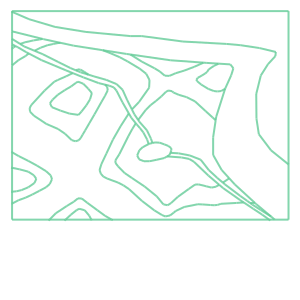

In [21]:
oo = shapely.ops.cascaded_union(lines)
oo

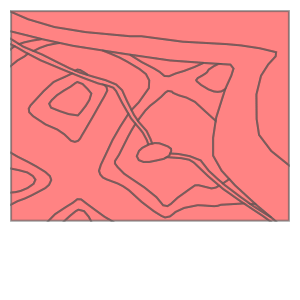

In [22]:
pols = []
for i in polygonize(oo):
    pols.append(i)
    
tos = MultiPolygon(pols)
tos

In [23]:
from shapely.geometry import mapping, Polygon
import fiona

# Here's an example Shapely geometry

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open('./my_shp2.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    for i, p in enumerate(tos.geoms):
        c.write({
            'geometry': mapping(p),
            'properties': {'id': i},
        })

# now we associate a point for each polygon

In [10]:
fids, ids_points = load_shapefile(units_ids)

units = extract_field(fids)
assert(len(ids_points) == len(units))

In [24]:
def get_points_inside(polygon, points):
    out = []
    for id, p in enumerate(points):
        if p.within(polygon):
            out.append(id)
            
    return out
            
        
outids = []
for pol in tos:
    ids = get_points_inside(pol, ids_points)
    thisunit = np.array(units)[ids]
    
    if len(ids) > 1:
        log.warning("more than two points were found in the same polygon")
    
        if np.all(thisunit == thisunit[0]):
            log.warning("no prob, because point to the same unit")
        
    if len(ids) < 1:
        log.error("cannot associate some polygons to an unit, missing points in unit definition file?")
    
    myunit = thisunit[0]
    outids.append(myunit)
    
    
    

# save and we have a consistent map

In [25]:
# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int', "unit_id": "str"},
}

# Write a new Shapefile
with fiona.open('./my_shp3.shp', 'w', 'ESRI Shapefile', schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    for i, p in enumerate(tos.geoms):
        c.write({
            'geometry': mapping(p),
            'properties': {'id': i, "unit_id":outids[i]},
        })